This code preprocesses the text, trains an LDA model, extracts topic distributions as features, and then trains a RandomForest classifier to predict whether a tweet is from a bot

In [1]:
import pandas as pd
import numpy as np
from gensim import corpora, models
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

# Load the dataset with the specified encoding
dataset_path = 'final_dataset_combined.csv'
data = pd.read_csv(dataset_path, encoding='ISO-8859-1')

def preprocess_text(text):
    stop_words = stopwords.words('english')
    text = str(text)  # Convert to string
    return [word for word in simple_preprocess(text, deacc=True) if word not in stop_words]

processed_docs = data['text'].map(preprocess_text)

dictionary = corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=15, no_above=0.5)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

lda_model = models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

def get_topic_distribution(bow_doc):
    topic_distribution = np.zeros(10)
    for topic, prob in lda_model.get_document_topics(bow_doc, minimum_probability=0):
        topic_distribution[topic] = prob
    return topic_distribution

features = np.vstack([get_topic_distribution(doc) for doc in bow_corpus])
labels = data['IsBot'].values

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dongm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


              precision    recall  f1-score   support

           0       0.87      0.92      0.90      5575
           1       0.92      0.87      0.89      5757

    accuracy                           0.90     11332
   macro avg       0.90      0.90      0.90     11332
weighted avg       0.90      0.90      0.90     11332



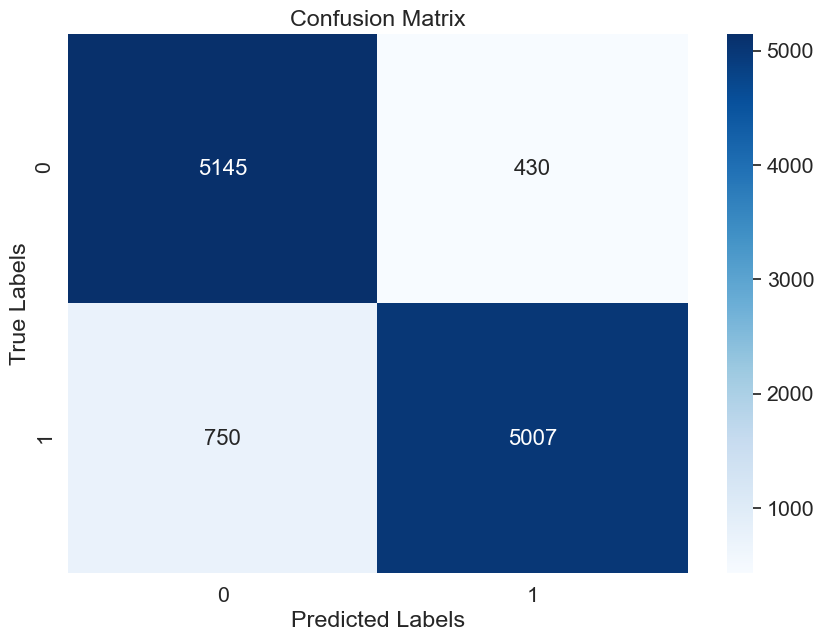

In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
